# Figure 5
Figure panels for UCSF-Biohub COVID Tissue Atlas. <br>
Nov 2021 <br>
Authors: Alejandro Granados, Ann Chen, Jonathan Liu <br>

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
from tqdm import tqdm
import sys

#add path where utils.py will be called
sys.path.append('/mnt/ibm_lg/covid_tissue_atlas/CovidTissueAtlas/cta_utils/')
import utils
import viz_utils

/data/alejandro/miniconda3/envs/scanpy/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


High level overview:
- get list of shared significant genes for a meta-type across several tissues
- generate pairwise plots of log2fc between two tissues
- quantify fraction coordinated vs. uncoordinated
- examine higher-order effects

In [2]:
# directory final object and figures will be saved to
FIG_DIR = '/mnt/ibm_lg/covid_tissue_atlas/figures/figure4/'

# if directory doesn't exist, make directory
if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)

#print package versions
print('package versions:')
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

# make sure you use these two parameters before saving figures to pdf
viz_utils.set_plotting_style() 
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'errorbar.capsize': 3})

sc.settings.verbosity = 3            
sc.set_figure_params(dpi=150)
sc.settings.figdir = FIG_DIR

package versions:
numpy 1.21.0
scipy 1.6.3
pandas 1.2.5
anndata 0.7.6
scanpy 1.7.2
seaborn 0.11.0


In [3]:
# Load data
dataPath = '/mnt/ibm_lg/covid_tissue_atlas/results/DGE'
fileName = 'shared_DE_signatures_filter_Feb22.csv'


 
data = pd.read_csv(os.path.join(dataPath, fileName), index_col=0)

In [4]:
data[data.tissue=='lung']

,pval,log2fc,cell_type,tissue,method,covariate,cell_class,cell_ontology_class,full_cell_type
gene,,,,,,,,,
ABL1,3.976709e-09,0.993220,macrophage,lung,MAST,ngenes,macrophage,lung macrophage,lung : macrophage
AC009093.2,2.339581e-41,-2.362811,macrophage,lung,MAST,ngenes,macrophage,lung macrophage,lung : macrophage
AC009690.1,9.772479e-17,-1.207992,macrophage,lung,MAST,ngenes,macrophage,lung macrophage,lung : macrophage
ACSL1,6.663193e-14,1.185771,macrophage,lung,MAST,ngenes,macrophage,lung macrophage,lung : macrophage
ACSL3,5.442552e-05,0.700441,macrophage,lung,MAST,ngenes,macrophage,lung macrophage,lung : macrophage
...,...,...,...,...,...,...,...,...,...
ZNF704,1.230438e-11,-1.353044,basal cell,lung,MAST,ngenes,basal,basal cell,lung : basal cell
ZNF91,1.094368e-04,-1.097591,basal cell,lung,MAST,ngenes,basal,basal cell,lung : basal cell
ZRANB2,3.600341e-11,-1.918086,basal cell,lung,MAST,ngenes,basal,basal cell,lung : basal cell


### Explore down-regulation

In [54]:
dow_df = data[data['log2fc']<0]
dow_df = dow_df[dow_df['pval'] < 1e-4]

dow_df.reset_index(inplace = True)

top_genes = dow_df.groupby(['gene','tissue']).size().sort_values(ascending=False)

top_genes = top_genes.reset_index() 

top_genes = top_genes.groupby(['gene']).size().sort_values(ascending = False)
top_genes = top_genes.reset_index() 
top_genes = top_genes[top_genes[0]>2]
top_genes

,gene,0
0,TNRC6A,5
1,NFATC3,5
2,MTRNR2L12,4
3,ZBTB16,4
4,LIFR,4
...,...,...
129,MXD4,3
130,ARGLU1,3
131,ARF1,3
132,ARHGEF15,3


In [58]:
dow_df = dow_df[dow_df.gene.isin(top_genes['gene'])].sort_values('gene')

In [71]:
dow_df.head() 

,gene,pval,log2fc,cell_type,tissue,method,covariate,cell_class,cell_ontology_class,full_cell_type
591,ABR,3.627088e-07,-2.726481,endothelial,prostate,MAST,ngenes,endothelial,endothelial cell,prostate : endothelial
755,ABR,1.026044e-11,-1.426210,endothelial,heart,MAST,ngenes,endothelial,cardiac endothelial cell,heart : endothelial
205,ABR,2.794495e-22,-2.836017,endothelial,liver,MAST,ngenes,endothelial,endothelial cell of hepatic sinusoid,liver : endothelial
756,AC007319.1,6.965068e-12,-0.669365,endothelial,heart,MAST,ngenes,endothelial,cardiac endothelial cell,heart : endothelial
455,AC007319.1,3.564017e-06,-1.620133,endothelial,kidney,MAST,ngenes,endothelial,endothelial cell,kidney : endothelial


In [77]:
df3 = df2[df2['gene'].isin(top_genes['gene'])].sort_values('gene')

In [84]:
df3[df3['cell_type']=='macrophage'].sort_values('gene').head(20)

,gene,pval,log2fc,cell_type,tissue,method,covariate,cell_class,cell_ontology_class,full_cell_type
6,ARRB1,1.213818e-14,-4.147427,macrophage,liver,MAST,ngenes,macrophage,Kupffer cell,liver : macrophage
84,ARRB1,1.013479e-05,-1.956770,macrophage,heart,MAST,ngenes,macrophage,macrophage,heart : macrophage
135,ARRB1,1.232652e-12,-1.238817,macrophage,lung,MAST,ngenes,macrophage,lung macrophage,lung : macrophage
7,CCNL1,2.105782e-08,-2.992727,macrophage,liver,MAST,ngenes,macrophage,Kupffer cell,liver : macrophage
85,CCNL1,7.093732e-06,-1.800339,macrophage,heart,MAST,ngenes,macrophage,macrophage,heart : macrophage
136,CCNL1,1.075435e-59,-2.712248,macrophage,lung,MAST,ngenes,macrophage,lung macrophage,lung : macrophage
9,CD36,8.150344e-05,-1.391990,macrophage,liver,MAST,ngenes,macrophage,Kupffer cell,liver : macrophage
11,CLEC12A,8.745791e-11,-2.534897,macrophage,liver,MAST,ngenes,macrophage,Kupffer cell,liver : macrophage
87,CLEC12A,7.203259e-06,-1.518818,macrophage,heart,MAST,ngenes,macrophage,macrophage,heart : macrophage
138,CLEC12A,9.349751e-17,-0.839610,macrophage,lung,MAST,ngenes,macrophage,lung macrophage,lung : macrophage


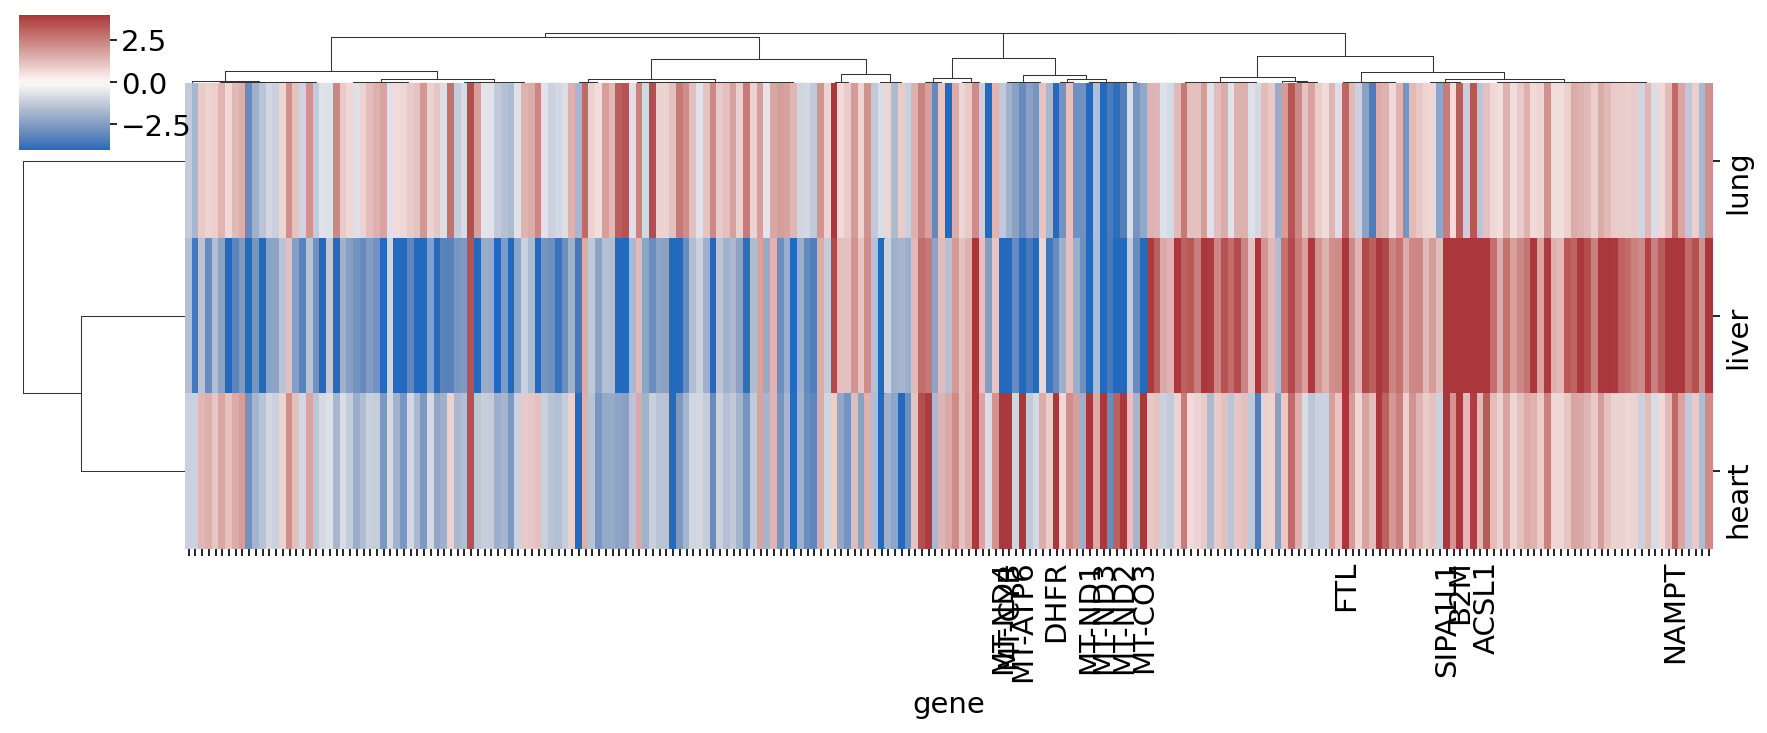

In [29]:
# Make a clustermap of shared significant genes for a cell class to motivate the quantification downstream
# Get dataframe for a cell class
cell_class_cluster = 'macrophage'
data_cluster = data[data['cell_class'] == cell_class_cluster][['log2fc','tissue']]

# Reshape into separate columns for each tissue type
df_list = []
for t in data_cluster['tissue'].unique():
    df_temp = data_cluster[data_cluster['tissue'] == t].copy()
    df_temp = df_temp.rename(columns={'log2fc':t})
    df_temp = df_temp[t]
    df_list.append(df_temp)
df_log2fc_cellclass = pd.concat(df_list, axis=1)

# Plot the clustermap


# Label only the genes that have large log2fc values in all tissues
x_label = []
for i in range(len(df_log2fc_cellclass)):
    if df_log2fc_cellclass.iloc[i,:].abs().sum() > 12:
        x_label.append(df_log2fc_cellclass.index[i])
    else:
        x_label.append('')
ax = sns.clustermap(df_log2fc_cellclass.transpose(), dendrogram_ratio=0.1, center=0, vmin=-4, vmax=4,
               method='complete', metric='correlation', 
                    xticklabels=x_label, cmap='vlag', figsize=(12,5))

# export
plt.gcf().savefig(FIG_DIR + 'clustermap.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [5]:
# # Plot the number of shared genes for tissues in macrophage, using SuperExactTest package for R
# import rpy2
# from rpy2.robjects import pandas2ri

# DGE_FILE = os.path.join(dataPath, fileName)

# %load_ext rpy2.ipython

# pandas2ri.activate()

# %Rpush FIG_DIR
# %Rpush DGE_FILE

In [6]:
# %%R
# library(dplyr)


# # Read DGE results from MAST


# dge_df = read.csv(DGE_FILE)

# # Filter tissue and cell type of interest (macrophage class, liver/heart/lung)
# dge_df %>% filter(cell_type =='macrophage') -> cell_class_df

# cell_class_df

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




          gene          pval     log2fc  cell_type tissue method covariate
1         ABL1  2.320011e-02 -1.3704874 macrophage  liver   MAST    ngenes
2   AC009093.2  2.417820e-08 -3.5351945 macrophage  liver   MAST    ngenes
3   AC009690.1  4.443810e-04 -1.5077865 macrophage  liver   MAST    ngenes
4        ACSL1  1.242819e-60  9.8787514 macrophage  liver   MAST    ngenes
5        ACSL3  3.666453e-11  2.8676330 macrophage  liver   MAST    ngenes
6         ACTB  3.272325e-14  2.8953272 macrophage  liver   MAST    ngenes
7        ACTG1  1.199154e-11  1.4833987 macrophage  liver   MAST    ngenes
8      ADAMTS2  1.498585e-16 -5.2423958 macrophage  liver   MAST    ngenes
9        ADAP2  1.318612e-21 -5.5059706 macrophage  liver   MAST    ngenes
10      ADGRE2  3.877521e-03 -1.6475981 macrophage  liver   MAST    ngenes
11        AFF1  7.192562e-07  3.4568097 macrophage  liver   MAST    ngenes
12     ANKRD44  1.380871e-04 -2.3428685 macrophage  liver   MAST    ngenes
13        AOAH  1.166070e

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  lung : macrophage
308 macrophage     lung macrophage  lung : macrophage
309 macrophage     lung macrophage  lung : macrophage
310 macrophage     lung macrophage  lung : macrophage
311 macrophage     lung macrophage  lung : macrophage
312 macrophage     lung macrophage  lung : macrophage
313 macrophage     lung macrophage  lung : macrophage
314 macrophage     lung macrophage  lung : macrophage
315 macrophage     lung macrophage  lung : macrophage
316 macrophage     lung macrophage  lung : macrophage
317 macrophage     lung macrophage  lung : macrophage
318 macrophage     lung macrophage  lung : macrophage
319 macrophage     lung macrophage  lung : macrophage
320 macrophage     lung macrophage  lung : macrophage
321 macrophage     lung macrophage  lung : macrophage
322 macrophage     lung macrophage  lung : macrophage
323 macrophage     lung macrophage  lung : macrophage
324 macrophage     lung macrophage  lung : macrophage
325 macrophage     lung macrophage  lung : macrophage
326 macr

In [7]:
# library(SuperExactTest)
# x=list(Pure_Urothliel=geneset_1,Nested=geneset_2,
#        Micropapillary=geneset_3)

# res=supertest(x, n=n_genes)

# pdf("Intersection_Pure_epithelial_1.pdf")
# plot(res, sort.by="size", margin=c(3,3,3,3), color.scale.pos=c(0.85,1), legend.pos=c(0.9,0.15))
# dev.off()

# pdf("Intersection_Pure_epithelial_2.pdf")
# plot(res, Layout="landscape", degree=1:3, sort.by="size", margin=c(0.5,5,1,2))
# dev.off()

SyntaxError: invalid syntax (<ipython-input-7-e3d6615d6793>, line 12)

In [30]:
# Create dictionary of cell classes
classes = list(data['cell_class'].unique())
cell_class = {}
for c in classes:
    data_class = data[data['cell_class'] == c] # Dataframe subset for this cell class

    # Separate into different tissue types
    tissues = list(data_class['tissue'].unique()) # Tissues for this cell class
    cell_class[c] = {} # Create dictionary of tissues for this cell class

    for tissue in tissues:
        cell_class[c][tissue] = data_class[data_class['tissue'] == tissue]

Text(0, 0.5, 'number of shared significant genes')

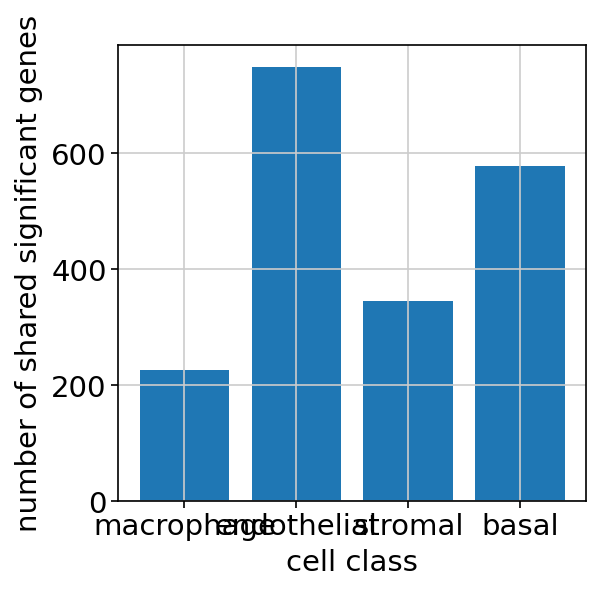

In [31]:
# Plot number of shared genes in each cell class

n_genes_class = [len(data[data['cell_class'] == x].index.unique()) for x in classes]
plt.figure()
plt.bar(classes, n_genes_class)
plt.xlabel('cell class')
plt.ylabel('number of shared significant genes')
#plt.yscale('log')

In [32]:
# Get pairwise combinations for each cell class
combinations = {}
combinations_df = {}
coordinations = {}

# For now, skip muscle and epithelial
#classes.remove('muscle')
#classes.remove('epithelial')

for c in classes:
    tissues = list(cell_class[c].keys())
    # Get all possible combinations of tissue types
    combinations[c] = list(itertools.combinations(tissues, 2))

    # Create dictionary to store pairwise log2fc dataframes and coordination values
    combinations_df[c] = {}
    coordinations[c] = {}
    
    for pairs in combinations[c]:
        # Create pairwise dataframe
        tis1 = pairs[0]
        tis2 = pairs[1]
        
        # Only use genes that exist in both tissues
        shared_genes = np.intersect1d(cell_class[c][tis1].index, cell_class[c][tis2].index)
        
        # Create dataframe
        combinations_df[c][pairs] = pd.concat([cell_class[c][tis1].loc[shared_genes,'log2fc'], 
                                            cell_class[c][tis2].loc[shared_genes,'log2fc']], axis=1, join='inner')
        combinations_df[c][pairs].columns = ['log2fc_' + tis1, 'log2fc_' + tis2]

        # Calculate coordination for each gene
        combinations_df[c][pairs]['coordination'] = 0 # Initialize new column of uncoordinated responses
        pos_coord_ind = np.logical_and(combinations_df[c][pairs]['log2fc_' + tis1] > 0,
                                  combinations_df[c][pairs]['log2fc_' + tis2] > 0) # Indices of pos coordinated responses
        neg_coord_ind = np.logical_and(combinations_df[c][pairs]['log2fc_' + tis1] < 0,
                                  combinations_df[c][pairs]['log2fc_' + tis2] < 0) # Indices of pos coordinated responses

        combinations_df[c][pairs].loc[pos_coord_ind, 'coordination'] = 1 # Set pos coordinated genes to 1
        combinations_df[c][pairs].loc[neg_coord_ind, 'coordination'] = 1 # Set neg coordinated genes to 1

        # Calculate overall coordination fraction for this combination
        N_coord = combinations_df[c][pairs]['coordination'].sum()
        N_uncoord = len(combinations_df[c][pairs]) - N_coord
        
        coordinations[c][pairs] = N_coord / (N_coord + N_uncoord)

Text(0.5, 1.0, 'stromal: liver/kidney, coordination = 0.5')

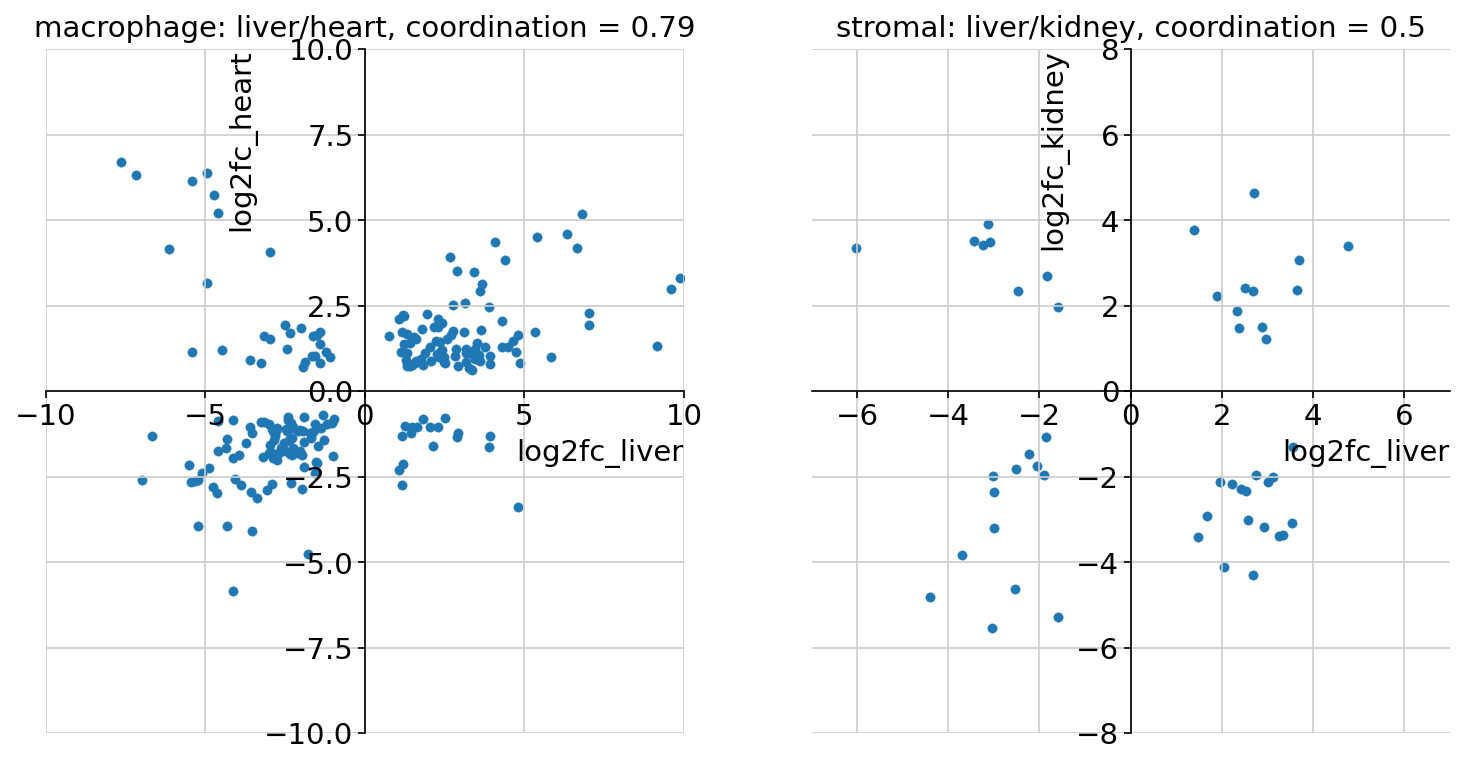

In [33]:
# Plot some sample pairwise log2fc scatter plots
p_class1 = 'macrophage'
p_class2 = 'stromal'
p_tis1 = 'liver'
p_tis2 = 'heart'
p_tis3 = 'kidney'

fig, ax = plt.subplots(1, 2, figsize=(12,6))

# macrophage, heart/liver
combinations_df[p_class1][(p_tis1, p_tis2)].plot.scatter('log2fc_' + p_tis1, 'log2fc_' + p_tis2, ax=ax[0])
ax[0].spines['top'].set_color('none')
ax[0].spines['bottom'].set_position('zero')
ax[0].spines['left'].set_position('zero')
ax[0].spines['right'].set_color('none')
ax[0].set_xlabel('log2fc_' + p_tis1, loc='right')
ax[0].set_ylabel('log2fc_' + p_tis2, loc='top')
ax[0].set_xlim((-10,10))
ax[0].set_ylim((-10,10))
ax[0].set_title(p_class1 + ': ' + p_tis1 + '/' + p_tis2 + ', coordination = ' + 
                str(np.round(coordinations[p_class1][(p_tis1, p_tis2)],2)))

# stromal, liver/kidney
combinations_df[p_class2][(p_tis1, p_tis3)].plot.scatter('log2fc_' + p_tis1, 'log2fc_' + p_tis3, ax=ax[1])
ax[1].spines['top'].set_color('none')
ax[1].spines['bottom'].set_position('zero')
ax[1].spines['left'].set_position('zero')
ax[1].spines['right'].set_color('none')
ax[1].set_xlabel('log2fc_' + p_tis1, loc='right')
ax[1].set_ylabel('log2fc_' + p_tis3, loc='top')
ax[1].set_xlim((-7,7))
ax[1].set_ylim((-8,8))
ax[1].set_title(p_class2 + ': ' + p_tis1 + '/' + p_tis3 + ', coordination = ' + 
                str(np.round(coordinations[p_class2][(p_tis1, p_tis3)],2)))


In [34]:
classes

['macrophage', 'endothelial', 'stromal', 'basal']

In [37]:
combinations_df['macrophage']

{('liver',
  'heart'):             log2fc_liver  log2fc_heart  coordination
 gene                                                
 ABL1           -1.370487     -1.076325             1
 AC009093.2     -3.535194     -1.230640             1
 AC009690.1     -1.507787     -1.071382             1
 ACSL1           9.878751      3.294791             1
 ACSL3           2.867633      1.222915             1
 ...                  ...           ...           ...
 ZCCHC7          1.308185      1.108021             1
 ZFAND5          4.289361      1.295176             1
 ZHX2            3.155182      0.841506             1
 ZNF407         -1.274844     -1.419370             1
 ZSWIM6         -2.472363     -1.097657             1
 
 [227 rows x 3 columns],
 ('liver',
  'lung'):             log2fc_liver  log2fc_lung  coordination
 gene                                               
 ABL1           -1.370487     0.993220             0
 AC009093.2     -3.535194    -2.362811             1
 AC009690.1     

In [9]:
# Estimate null hypothesis expected distribution of coordination for each cell class
# To do this, randomly shuffle the rows in the log2fc pairwise dataframe so we examine 
# coordination of Gene A with Gene B. We we would expect this to not be coordinated, with
# coordination approximately 0.5. Use a Monte Carlo sampling approach

N_samples = 1000 # Number of random samples

coordinations_control = {}
for i in range(len(classes)):
    coordinations_control[classes[i]] = {}
    for pairs in combinations[classes[i]]:
        coordinations_control[classes[i]][pairs] = np.zeros(N_samples)
        # Create random shuffled dataframes
        for j in tqdm(range(N_samples)):
            df_old = combinations_df[classes[i]][pairs]
            row_ind = np.array(range(len(df_old)))
            
            # Get shuffled row order
            np.random.shuffle(row_ind)
            
            # Create temporary shuffled dataframe
            tis1 = pairs[0]
            tis2 = pairs[1]
            # Keep the first column the same and the second one re-ordered
            df_rand = df_old.copy()
            df_rand.loc[:,'log2fc_' + tis2] = np.array(df_old['log2fc_' + tis2])[row_ind]
            
            # Calculate the coordinations for this shuffled dataframe
            df_rand['coordination'] = 0 # Initialize new column of uncoordinated responses
            pos_coord_ind = np.logical_and(df_rand['log2fc_' + tis1] > 0,
                                      df_rand['log2fc_' + tis2] > 0) # Indices of pos coordinated responses
            neg_coord_ind = np.logical_and(df_rand['log2fc_' + tis1] < 0,
                                      df_rand['log2fc_' + tis2] < 0) # Indices of pos coordinated responses

            df_rand.loc[pos_coord_ind, 'coordination'] = 1 # Set pos coordinated genes to 1
            df_rand.loc[neg_coord_ind, 'coordination'] = 1 # Set neg coordinated genes to 1
            
            # Save the coordination value
            N_coord = df_rand['coordination'].sum()
            N_uncoord = len(df_rand) - N_coord
            coordinations_control[classes[i]][pairs][j] = N_coord / (N_coord + N_uncoord)
            
        print(classes[i] + str(pairs) + ' done.')
print('Null coordination distributions calculated.')

  9%|▉         | 92/1000 [00:00<00:02, 439.65it/s]

macrophage('liver', 'heart') done.


  9%|▉         | 90/1000 [00:00<00:02, 447.39it/s]

macrophage('liver', 'lung') done.


  9%|▉         | 92/1000 [00:00<00:02, 444.32it/s]

macrophage('heart', 'lung') done.


  4%|▍         | 44/1000 [00:00<00:02, 434.86it/s]

endothelial('liver', 'kidney') done.


  4%|▍         | 44/1000 [00:00<00:02, 431.73it/s]

endothelial('liver', 'prostate') done.


  9%|▉         | 88/1000 [00:00<00:02, 434.91it/s]

endothelial('liver', 'heart') done.


  9%|▉         | 92/1000 [00:00<00:02, 447.85it/s]

endothelial('liver', 'lung') done.


  9%|▉         | 90/1000 [00:00<00:02, 439.73it/s]

endothelial('kidney', 'prostate') done.


  9%|▉         | 92/1000 [00:00<00:02, 449.34it/s]

endothelial('kidney', 'heart') done.


  9%|▉         | 88/1000 [00:00<00:02, 437.53it/s]

endothelial('kidney', 'lung') done.


  4%|▍         | 45/1000 [00:00<00:02, 440.86it/s]

endothelial('prostate', 'heart') done.


  9%|▉         | 90/1000 [00:00<00:02, 446.57it/s]

endothelial('prostate', 'lung') done.


  9%|▉         | 92/1000 [00:00<00:02, 451.97it/s]

endothelial('heart', 'lung') done.


  4%|▍         | 45/1000 [00:00<00:02, 448.16it/s]

stromal('liver', 'kidney') done.


  5%|▍         | 47/1000 [00:00<00:02, 461.15it/s]

stromal('liver', 'prostate') done.


  5%|▍         | 46/1000 [00:00<00:02, 450.32it/s]

stromal('liver', 'heart') done.


  9%|▊         | 86/1000 [00:00<00:02, 428.87it/s]

stromal('liver', 'lung') done.


  9%|▉         | 89/1000 [00:00<00:02, 442.74it/s]

stromal('kidney', 'prostate') done.


  5%|▍         | 46/1000 [00:00<00:02, 453.72it/s]

stromal('kidney', 'heart') done.


  9%|▉         | 90/1000 [00:00<00:02, 448.69it/s]

stromal('kidney', 'lung') done.


  5%|▍         | 46/1000 [00:00<00:02, 451.52it/s]

stromal('prostate', 'heart') done.


  5%|▍         | 46/1000 [00:00<00:02, 458.22it/s]

stromal('prostate', 'lung') done.


  4%|▍         | 44/1000 [00:00<00:02, 438.04it/s]

stromal('heart', 'lung') done.


100%|██████████| 1000/1000 [00:02<00:00, 435.32it/s]

basal('prostate', 'lung') done.
Null coordination distributions calculated.


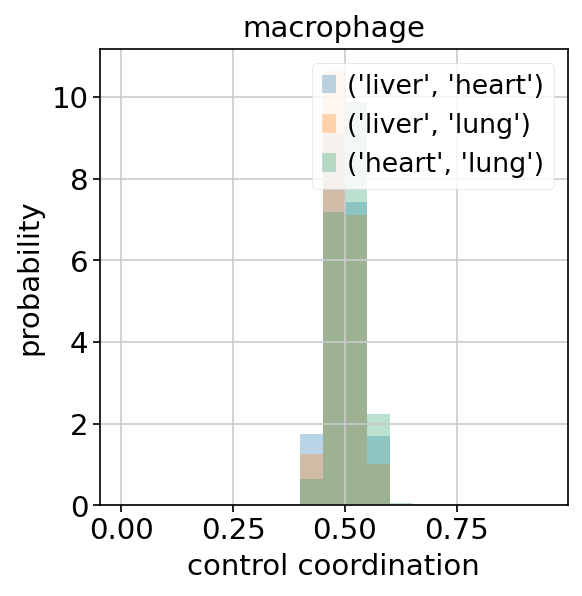

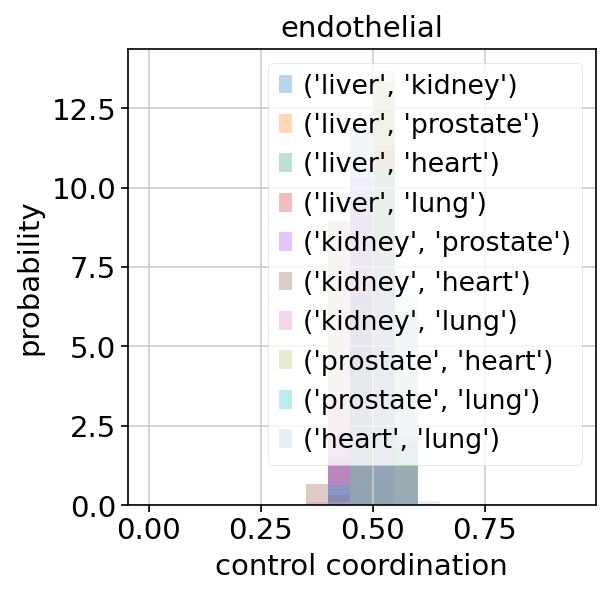

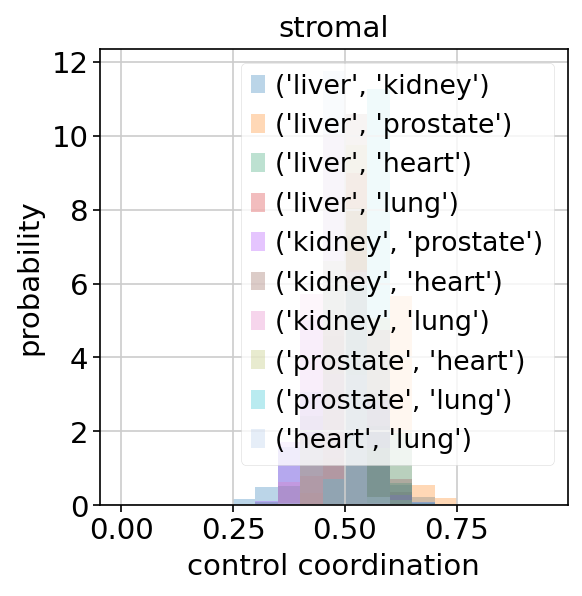

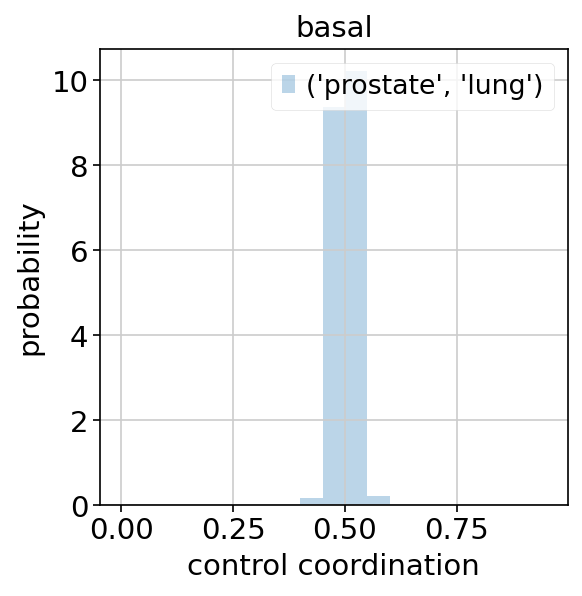

In [10]:
# Make master dataframe of control calculated coordinations
coord_control_df = pd.DataFrame.from_dict(coordinations_control)

# Plot distributions
bins = np.arange(0,1,0.05)
for c in classes:
    plt.figure()
    for pairs in combinations[c]:
        plt.hist(coord_control_df.loc[pairs,c], 
                 density=True, alpha=0.3, bins=bins, label=str(pairs))
    plt.xlabel('control coordination')
    plt.ylabel('probability')
    plt.legend()
    plt.title(c)

(0.0, 1.0)

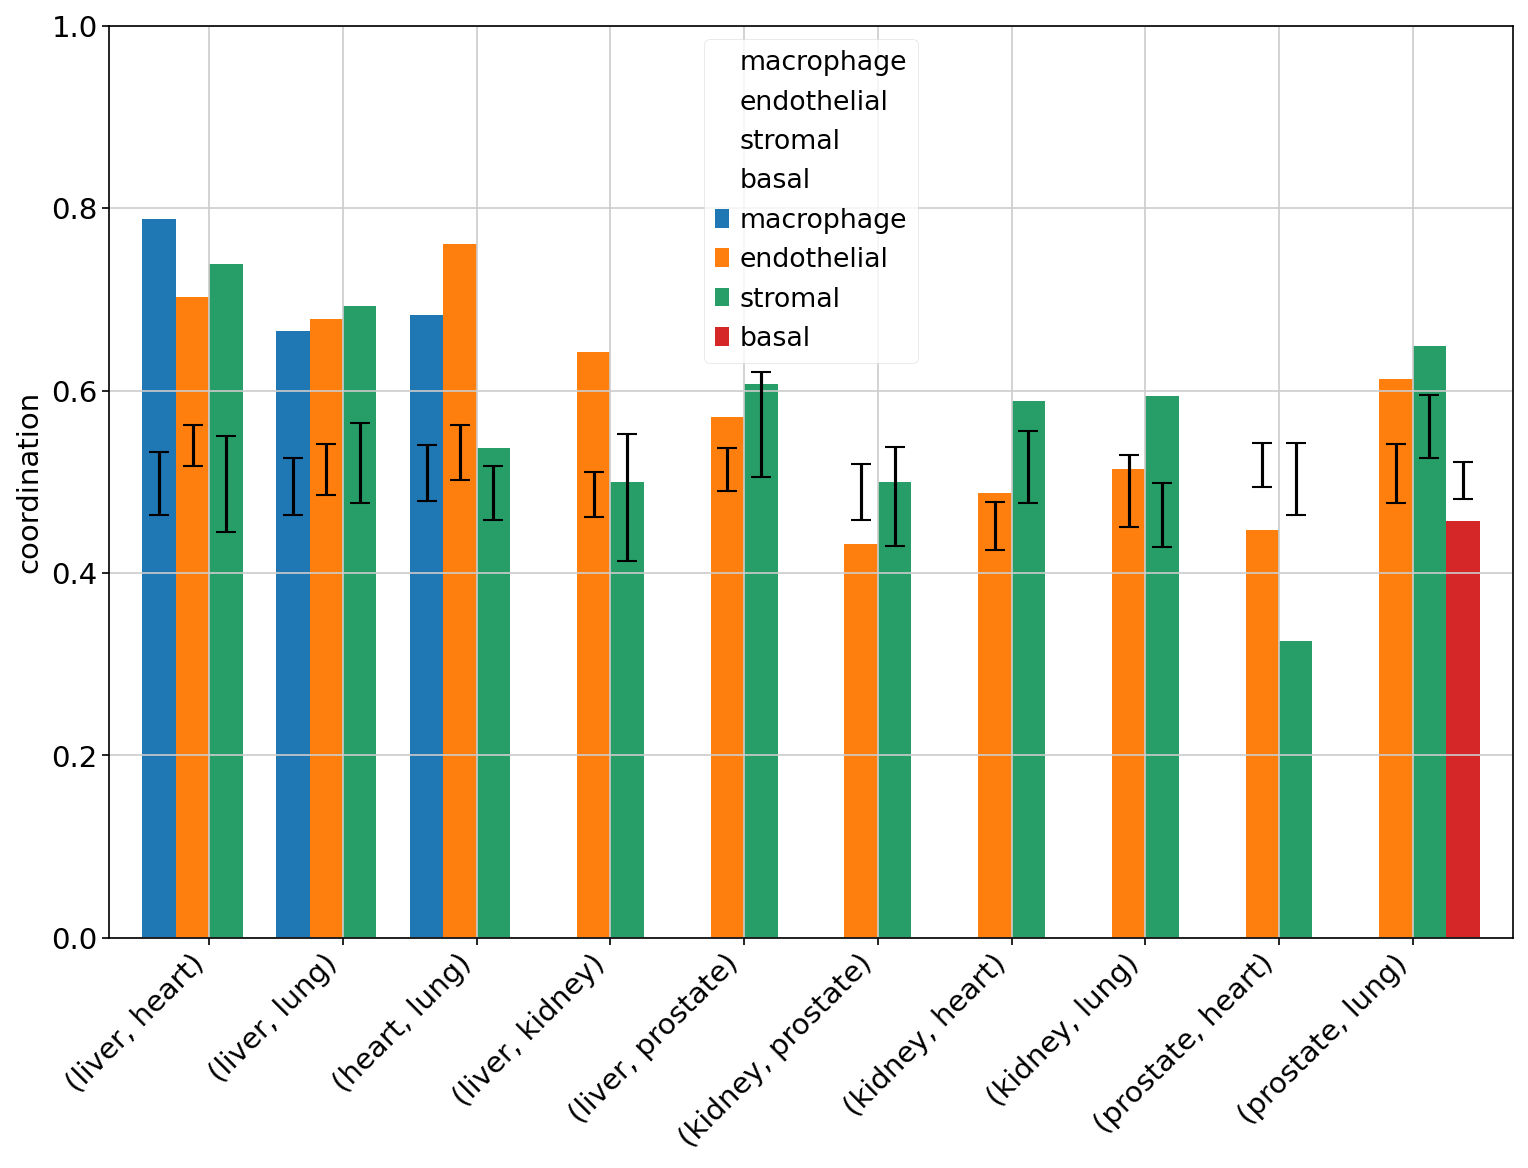

In [24]:
# Make dataframe of mean + SD of control calculated coordinations
coord_control_df_mean = coord_control_df.copy()
coord_control_df_sd = coord_control_df.copy()

for c in classes:
    for pairs in combinations[c]:
        coord_control_df_mean.loc[pairs,c] = np.mean(coord_control_df.loc[pairs,c])
        coord_control_df_sd.loc[pairs,c] = np.std(coord_control_df.loc[pairs,c])
        
# Make master dataframe of calculated coordinations
coord_df = pd.DataFrame.from_dict(coordinations)
        
# Bar plot summary of coordinations (controls + data)
fig, ax = plt.subplots(figsize=(12,8))
coord_control_df_mean.plot.bar(ax=ax, width=1, yerr=coord_control_df_sd, capsize=5, alpha=0) # Control coordinations
#coord_df.plot.line(ax=ax, linestyle='', marker='o')
coord_df.plot.bar(ax=ax, width=1, alpha=1) # data
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('coordination')
ax.set_ylim((0,1))

In [12]:
p_tis3

'kidney'

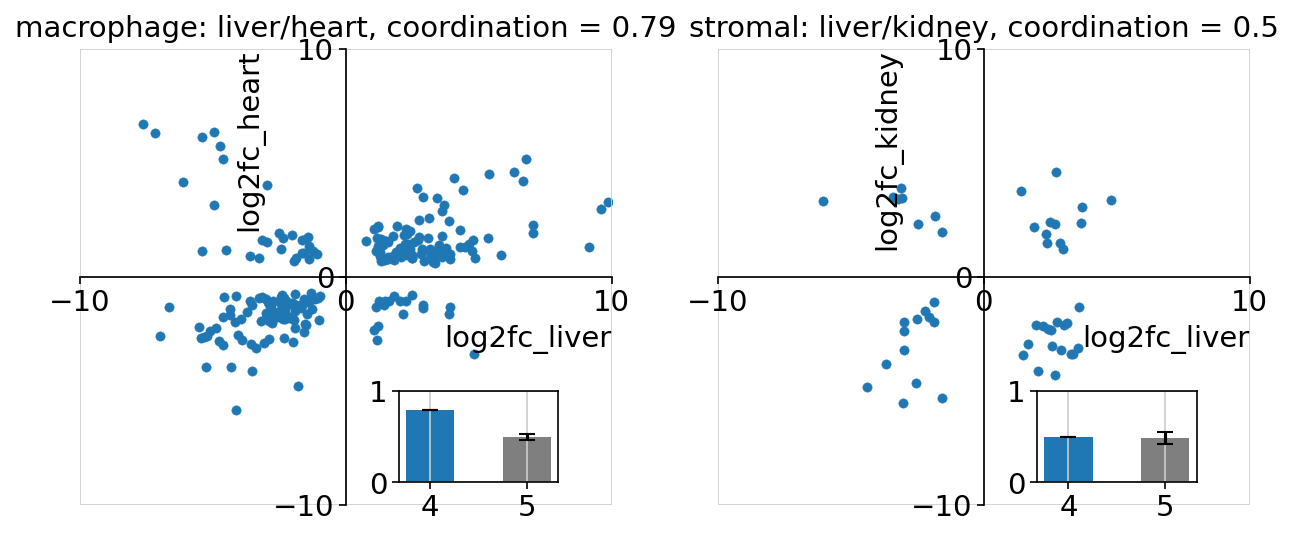

In [13]:
# Plot some scatterplots of coordination along with bar plots of coordination statistic for data + control
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# macrophage, heart/liver
combinations_df[p_class1][(p_tis1, p_tis2)].plot.scatter('log2fc_' + p_tis1, 'log2fc_' + p_tis2, ax=ax[0])
ax[0].spines['top'].set_color('none')
ax[0].spines['bottom'].set_position('zero')
ax[0].spines['left'].set_position('zero')
ax[0].spines['right'].set_color('none')
ax[0].set_xlabel('log2fc_' + p_tis1, loc='right')
ax[0].set_ylabel('log2fc_' + p_tis2, loc='top')
ax[0].set_xlim((-10,10))
ax[0].set_ylim((-10,10))
ax[0].set_xticks([-10,0,10])
ax[0].set_yticks([-10,0,10])
ax[0].set_title(p_class1 + ': ' + p_tis1 + '/' + p_tis2 + ', coordination = ' + 
                str(np.round(coordinations[p_class1][(p_tis1, p_tis2)],2)))

# barplots
ax1 = ax[0].inset_axes([2, -9, 6, 4], transform=ax[0].transData)
x_bar = [4,5]
y_bar = [coord_df.loc[('liver','heart'),'macrophage'], coord_control_df_mean.loc[('liver','heart'),'macrophage']]
y_err = [0, coord_control_df_sd.loc[('liver','heart'),'macrophage']]
colors = ['tab:blue','tab:gray']

ax1.bar(x_bar, y_bar, yerr=y_err, width=0.5, capsize=4, color=colors)
ax1.set_ylim((0,1))
ax1.set_yticks([0,1])
#ax1.legend()

# stromal, liver/kidney
combinations_df[p_class2][(p_tis1, p_tis3)].plot.scatter('log2fc_' + p_tis1, 'log2fc_' + p_tis3, ax=ax[1])
ax[1].spines['top'].set_color('none')
ax[1].spines['bottom'].set_position('zero')
ax[1].spines['left'].set_position('zero')
ax[1].spines['right'].set_color('none')
ax[1].set_xlabel('log2fc_' + p_tis1, loc='right')
ax[1].set_ylabel('log2fc_' + p_tis3, loc='top')
ax[1].set_xlim((-10,10))
ax[1].set_ylim((-10,10))
ax[1].set_xticks([-10,0,10])
ax[1].set_yticks([-10,0,10])
ax[1].set_title(p_class2 + ': ' + p_tis1 + '/' + p_tis3 + ', coordination = ' + 
                str(np.round(coordinations[p_class2][(p_tis1, p_tis3)],2)))

# barplots
ax2 = ax[1].inset_axes([2, -9, 6, 4], transform=ax[1].transData)
x_bar = [4,5]
y_bar = [coord_df.loc[('liver','kidney'),'stromal'], coord_control_df_mean.loc[('liver','kidney'),'stromal']]
y_err = [0, coord_control_df_sd.loc[('liver','kidney'),'stromal']]
colors = ['tab:blue','tab:gray']

ax2.bar(x_bar, y_bar, yerr=y_err, width=0.5, capsize=4, color=colors)
ax2.set_ylim((0,1))
ax2.set_yticks([0,1])

# export
fig.savefig(FIG_DIR + 'scatterplots.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [56]:
p_class1 = 'macrophage'
p_tis1 = 'liver'
p_tis2 = 'heart'

tissue_pair = combinations_df[p_class1][(p_tis1, p_tis2)]
tissue_pair = tissue_pair[tissue_pair['coordination']==1]
tissue_pair['prodFC'] = tissue_pair.loc[:,tissue_pair.columns[0]] * tissue_pair.loc[:,tissue_pair.columns[1]]  

tissue_pair = tissue_pair.sort_values(by='prodFC', ascending = False)
tissue_pair['rank'] = tissue_pair['prodFC'].rank() 

tissue_pair.head(20) 

<ipython-input-56-420b78fb8aa3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tissue_pair['prodFC'] = tissue_pair.loc[:,tissue_pair.columns[0]] * tissue_pair.loc[:,tissue_pair.columns[1]]


,log2fc_liver,log2fc_heart,coordination,prodFC,rank
gene,,,,,
FTL,6.795898,5.182261,1,35.218115,179.0
ACSL1,9.878751,3.294791,1,32.548424,178.0
B2M,6.339922,4.587542,1,29.084662,177.0
NAMPT,9.605107,2.986867,1,28.689180,176.0
SIPA1L1,6.657072,4.193288,1,27.915020,175.0
FTH1,5.386407,4.513196,1,24.309912,174.0
EDA,-4.133342,-5.842492,1,24.149019,173.0
ADAMTS2,-5.242396,-3.951244,1,20.713984,172.0
CD163,-6.990029,-2.588709,1,18.095149,171.0


In [86]:
# Plot some scatterplots of coordination along with bar plots of coordination statistic for data + control
import matplotlib.patheffects as path_effects
def coordinationScatter(p_class1, p_tis1, p_tis2,ax,n_genes = 10, manual_gene_list = []):
    # macrophage, heart/liver
    combinations_df[p_class1][(p_tis1, p_tis2)].plot.scatter('log2fc_' + p_tis1, 'log2fc_' + p_tis2, ax=ax)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')

    ax.set_xlim((-10,10))
    ax.set_ylim((-10,10))
    ax.set_xticks([-10,0,10])
    ax.set_yticks([-10,0,10])
    ax.set_title(p_class1 + ': ' + p_tis1 + '/' + p_tis2 + ', coordination = ' + 
                    str(np.round(coordinations[p_class1][(p_tis1, p_tis2)],2)))
    ax.set_xlabel('LFC ' + p_tis1, x =0, y = -2)
    ax.set_ylabel('LFC ' + p_tis2, y= 0,x=-2)

    #annotate top genes 
    if len(manual_gene_list)==0:
        top_genes = selectTopGenes(p_class1, p_tis1,p_tis2,n=n_genes)
    else:
        combination_genes = combinations_df[p_class1][(p_tis1, p_tis2)]

        genes_present = [x for x in manual_gene_list if x in combination_genes.index.to_list() ]
        top_genes = combination_genes.loc[genes_present]
        
        
        
        
    Px = top_genes[top_genes.columns[0]].values
    Py = top_genes[top_genes.columns[1]].values
    gene_names = top_genes.index.to_series()

    for i in range(len(gene_names)):
        text = ax.annotate(
            gene_names[i],
            xy=(Px[i], Py[i]),
            xycoords="data",
            xytext=(np.random.randint(0, 50), np.random.randint(0, 50)),
            textcoords="offset points",
            ha="center",
            size="small",
            arrowprops=dict(
                arrowstyle="-", shrinkA=0, shrinkB=5, color="black", linewidth=0.25
            ),
        )
#         text.set_path_effects(
#             [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
#         )
#         text.arrow_patch.set_path_effects(
#             [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
#         )
    
    
    # barplots
    ax1 = ax.inset_axes([2, -9, 6, 4], transform=ax.transData)
    x_bar = [4,5]
    y_bar = [coord_df.loc[(p_tis1,p_tis2),p_class1], coord_control_df_mean.loc[(p_tis1,p_tis2),p_class1]]
    y_err = [0, coord_control_df_sd.loc[(p_tis1,p_tis2),p_class1]]
    colors = ['tab:blue','tab:gray']

    ax1.bar(x_bar, y_bar, yerr=y_err, width=0.5, capsize=4, color=colors)
    ax1.set_ylim((0,1))
    ax1.set_yticks([0,1])
    #ax1.legend()
    

In [87]:
def selectTopGenes(p_class1, p_tis1,p_tis2,n=10):
    tissue_pair = combinations_df[p_class1][(p_tis1, p_tis2)]
    tissue_pair = tissue_pair[tissue_pair['coordination']==1]
    tissue_pair['prodFC'] = tissue_pair.loc[:,tissue_pair.columns[0]] * tissue_pair.loc[:,tissue_pair.columns[1]]  

    tissue_pair = tissue_pair.sort_values(by='prodFC', ascending = False)
    tissue_pair['rank'] = tissue_pair['prodFC'].rank() 
    tissue_pair.nlargest(columns=['rank'],n=10)
    
    return(tissue_pair)

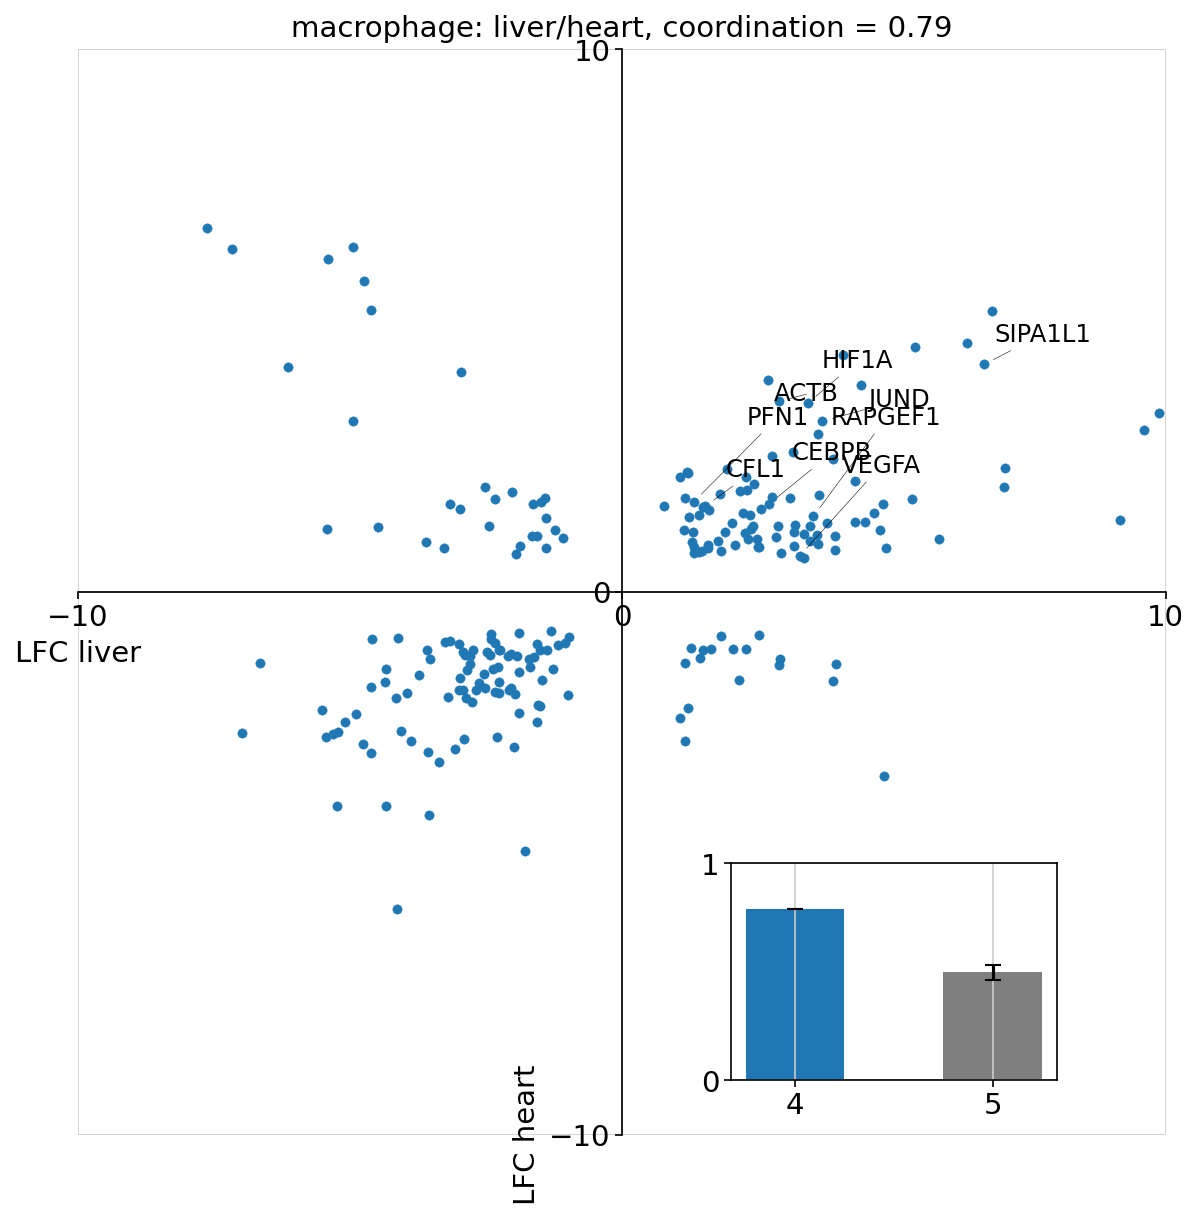

In [89]:
    
fig, ax = plt.subplots(figsize=(8,8))
this_class='macrophage'
tissue1='liver'
tissue2='heart'

show_genes = ['HIF1A', 'VEGFA','ACTB', 'CFL1','JUND','CEBPB','RAPGEF1','PFN1','SIPA1L1']
coordinationScatter(this_class,tissue1,tissue2,ax,n_genes=10, manual_gene_list = show_genes)
plt.tight_layout()
plt.show()

fig.savefig(FIG_DIR + "coordScatter_"+ this_class+ "_"+ tissue1+"_"+tissue2+'.pdf', dpi=300, bbox_inches='tight', transparent=True)

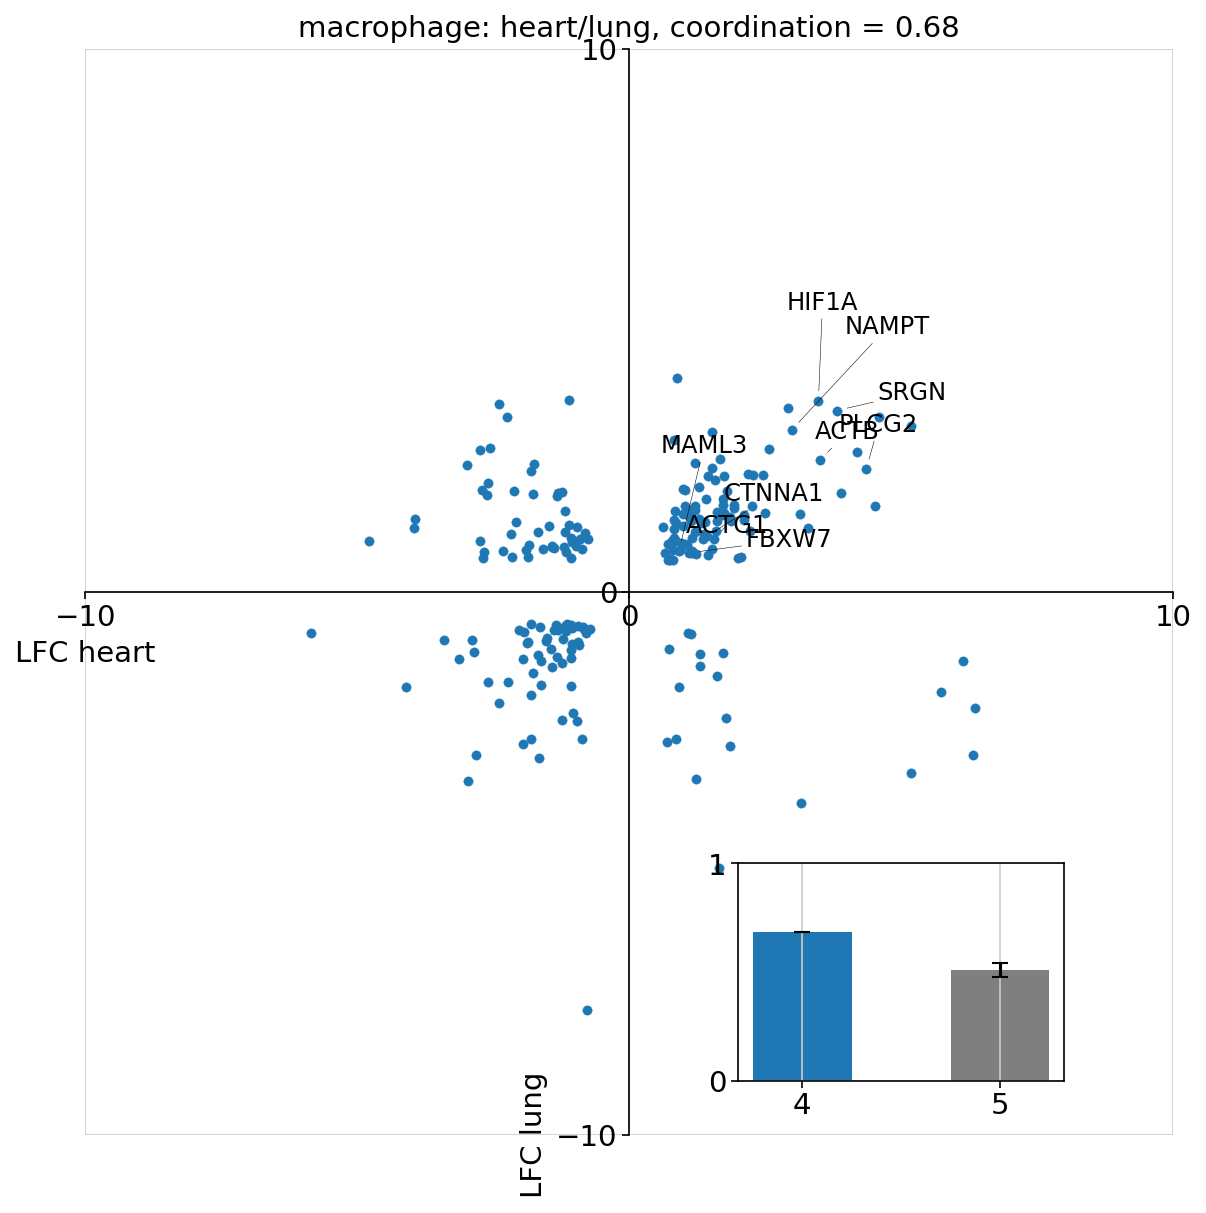

In [95]:
    
fig, ax = plt.subplots(figsize=(8,8))
this_class='macrophage'
tissue2='lung'
tissue1='heart'

show_genes = ['HIF1A', 'PLCG2','CTNNA1', 'ACTB','MAML3','FBXW7','ACTG1','SRGN','NAMPT']
coordinationScatter(this_class,tissue1,tissue2,ax,n_genes=10, manual_gene_list = show_genes)
plt.tight_layout()
plt.show()

fig.savefig(FIG_DIR + "coordScatter_"+ this_class+ "_"+ tissue1+"_"+tissue2+'.pdf', dpi=300, bbox_inches='tight', transparent=True)

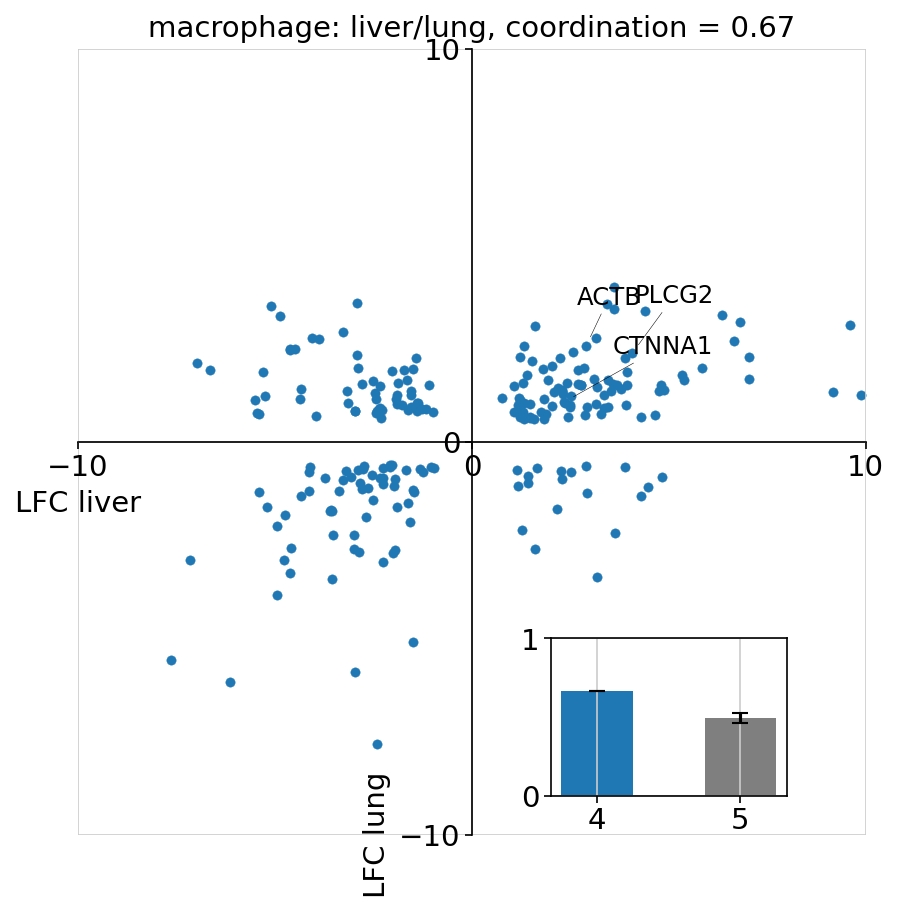

In [93]:
    
fig, ax = plt.subplots(figsize=(6,6))
this_class='macrophage'
tissue2='lung'
tissue1='liver'

show_genes = ['FLT1', 'PLCG2','CTNNA1', 'ACTB','CTNND1','PXN','FYN', 'PXN3']
coordinationScatter(this_class,tissue1,tissue2,ax,n_genes=10, manual_gene_list = show_genes)

plt.tight_layout()
plt.show()

fig.savefig(FIG_DIR + "coordScatter_"+ this_class+ "_"+ tissue1+"_"+tissue2+'.pdf', dpi=300, bbox_inches='tight', transparent=True)

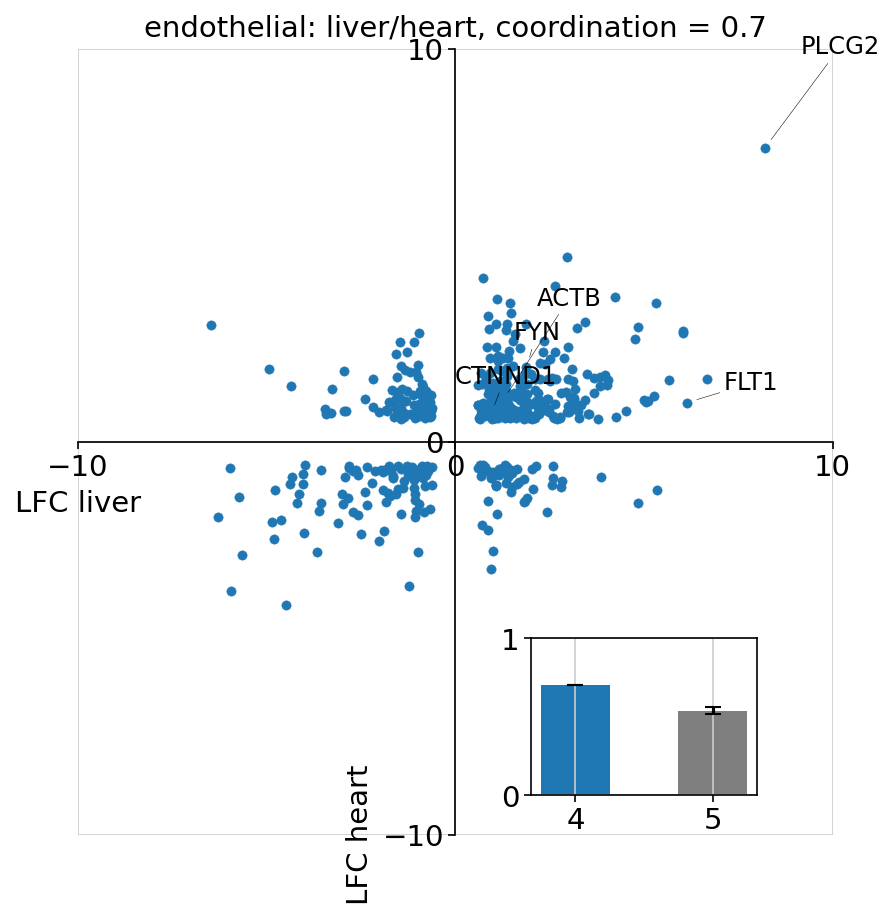

In [94]:
    
fig, ax = plt.subplots(figsize=(6,6))
this_class='endothelial'
tissue1='liver'
tissue2='heart'

show_genes = ['FLT1', 'PLCG2','CTNNA1', 'ACTB','CTNND1','PXN','FYN', 'PXN3']
coordinationScatter(this_class,tissue1,tissue2,ax,n_genes=10, manual_gene_list = show_genes)

plt.tight_layout()
plt.show()

fig.savefig(FIG_DIR + "coordScatter_"+ this_class+ "_"+ tissue1+"_"+tissue2+'.pdf', dpi=300, bbox_inches='tight', transparent=True)

<ipython-input-42-7fc2e557ccb6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tissue_pair['prodFC'] = tissue_pair.loc[:,tissue_pair.columns[0]] * tissue_pair.loc[:,tissue_pair.columns[1]]


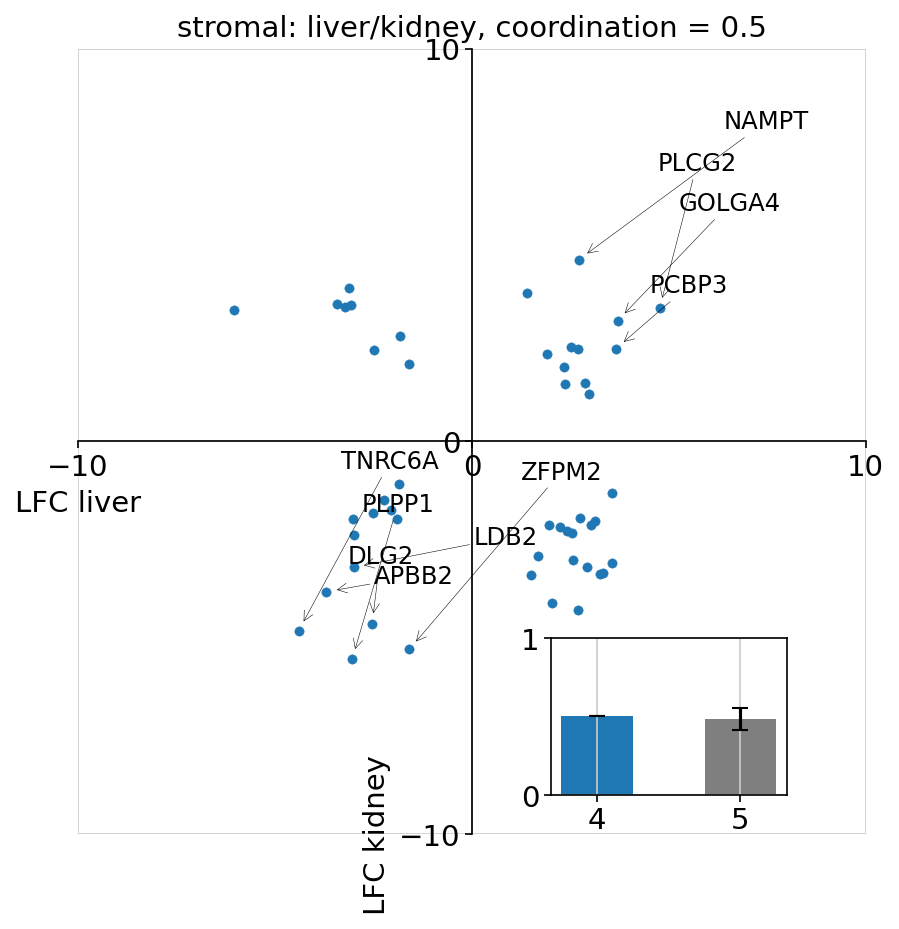

In [52]:
    
fig, ax = plt.subplots(figsize=(6,6))
this_class='stromal'
tissue1='liver'
tissue2='kidney'

coordinationScatter(this_class,tissue1,tissue2,ax,n_genes=10)
plt.tight_layout()
plt.show()

fig.savefig(FIG_DIR + "coordScatter_"+ this_class+ "_"+ tissue1+"_"+tissue2+'.pdf', dpi=300, bbox_inches='tight', transparent=True)

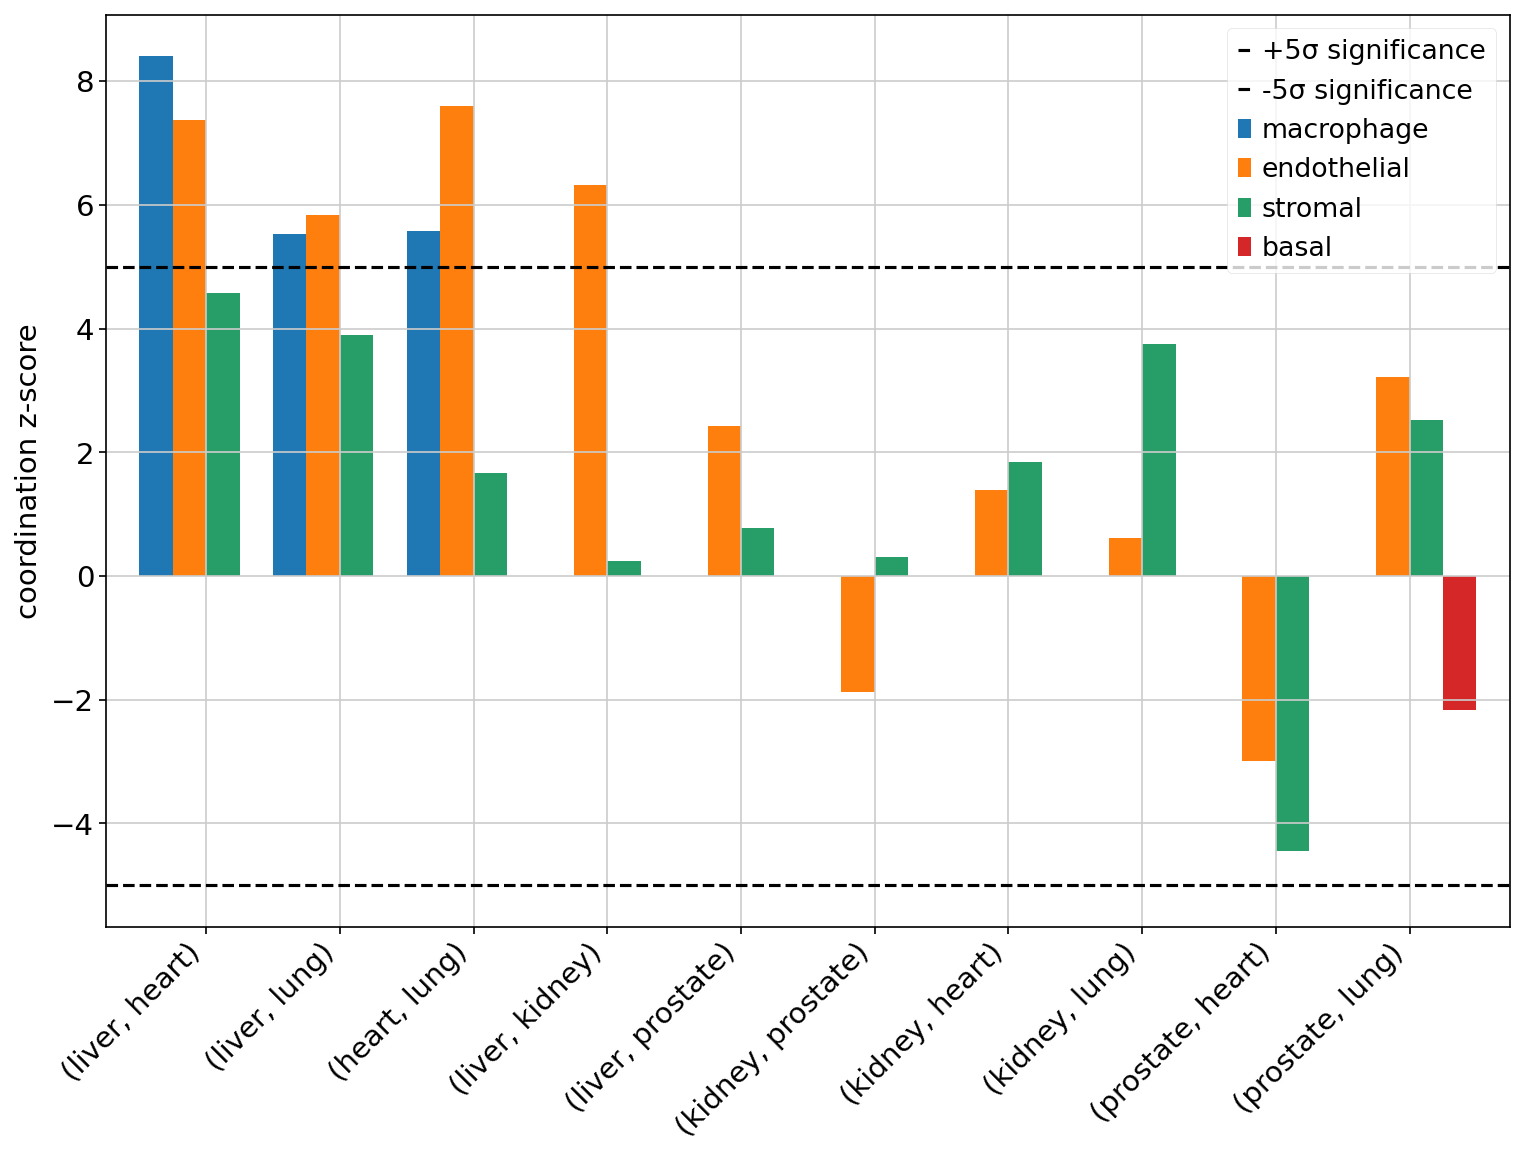

In [39]:
# Calculate z score of each coordination
coord_df_zscore = (coord_df - coord_control_df_mean) / coord_control_df_sd

# Plot z scores
fig, ax = plt.subplots(figsize=(12,8))
coord_df_zscore.plot.bar(ax=ax, width=1) # Control coordinations
ax.plot(ax.get_xlim(),[5,5], linestyle='--', color='black', label='+5σ significance') # 5 sigma significance
ax.plot(ax.get_xlim(),[-5,-5], linestyle='--', color='black', label='-5σ significance') # -5 sigma significance
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('coordination z-score')
ax.legend()

# export
fig.savefig(FIG_DIR + 'zscores.pdf', dpi=300, bbox_inches='tight', transparent=True)

### Plot the final figure
(note that sns.clustermap creates a separate figure so we will not add it to the combined panels here)

NameError: name 'combinations_df' is not defined

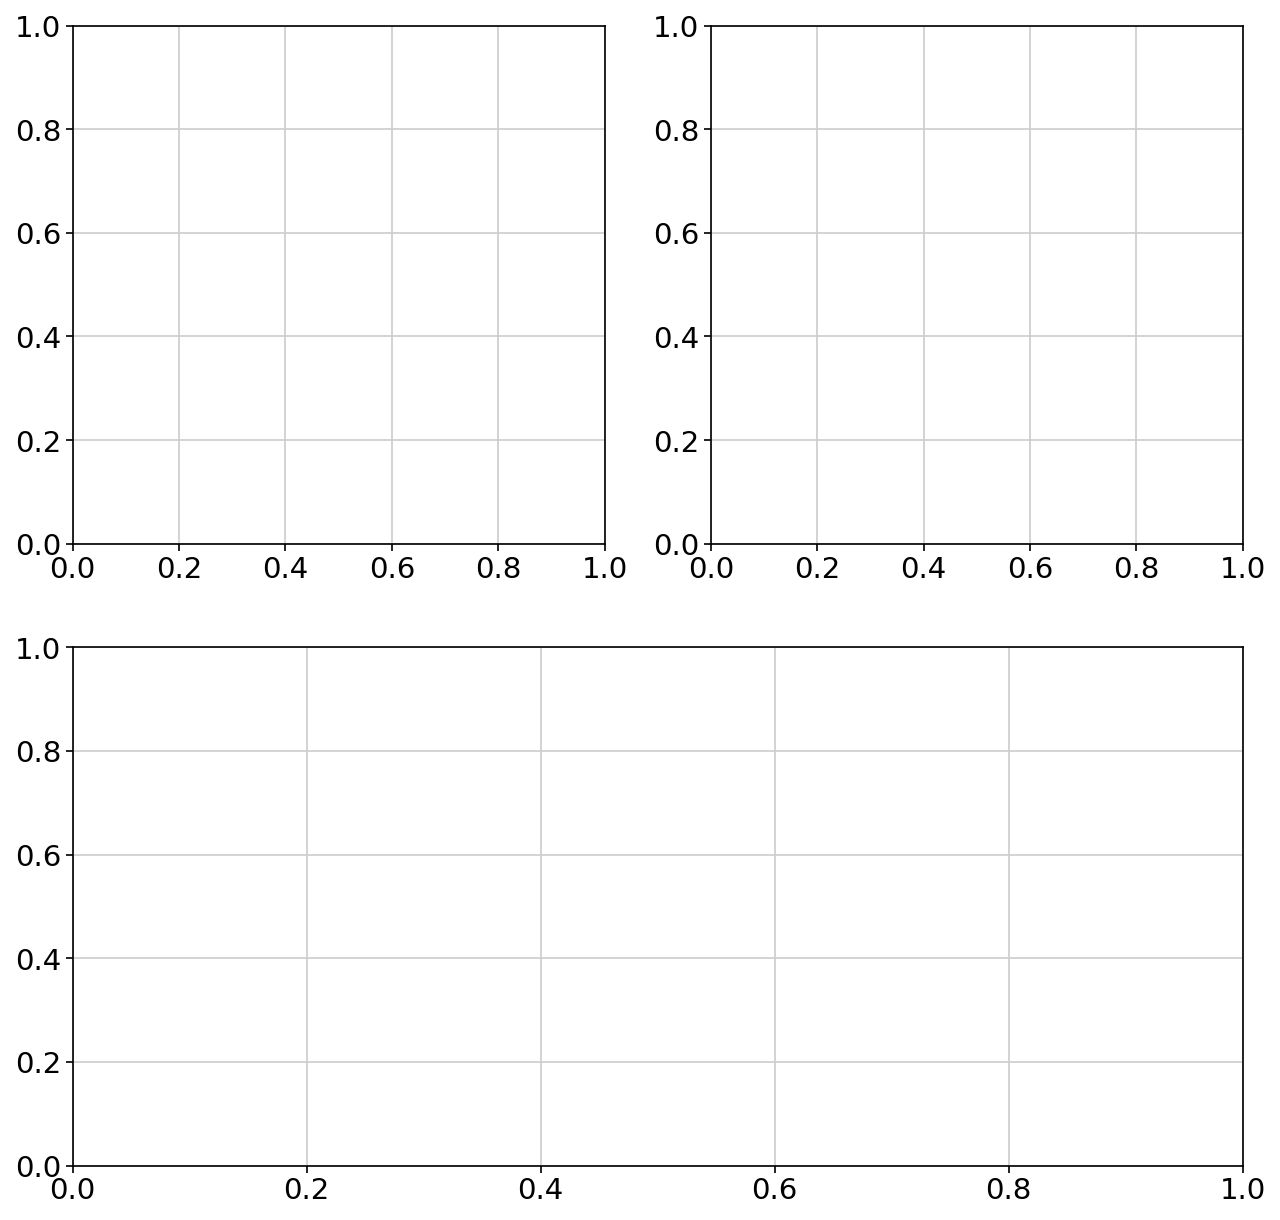

In [8]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
gs = ax[0,0].get_gridspec() #Get gridspecs

# remove the underlying axes for Panel A and D
for i in [1]:
    for j in [0,1]:
        ax[i,j].remove()

axbig1 = fig.add_subplot(gs[1, 0:2])

# Panel B: scatter plot for macrophages
ax_temp = ax[0,0]
combinations_df[p_class1][(p_tis1, p_tis2)].plot.scatter('log2fc_' + p_tis1, 'log2fc_' + p_tis2, ax=ax_temp)
ax_temp.spines['top'].set_color('none')
ax_temp.spines['bottom'].set_position('zero')
ax_temp.spines['left'].set_position('zero')
ax_temp.spines['right'].set_color('none')
ax_temp.set_xlabel('log2fc_' + p_tis1, loc='right')
ax_temp.set_ylabel('log2fc_' + p_tis2, loc='top')
ax_temp.set_xlim((-10,10))
ax_temp.set_ylim((-10,10))
ax_temp.set_xticks([-10,0,10])
ax_temp.set_yticks([-10,0,10])
ax_temp.grid(False)

axbar1 = ax_temp.inset_axes([2, -9, 6, 4], transform=ax_temp.transData)
x_bar = [4,5]
y_bar = [coord_df.loc[('liver','heart'),'macrophage'], coord_control_df_mean.loc[('liver','heart'),'macrophage']]
y_err = [0, coord_control_df_sd.loc[('liver','heart'),'macrophage']]
colors = ['tab:blue','tab:gray']

axbar1.bar(x_bar, y_bar, yerr=y_err, width=0.5, capsize=4, color=colors)
axbar1.set_ylim((0,1))
axbar1.set_yticks([0,1])
axbar1.grid(False)

# Panel C: scatter plot for stromal
ax_temp = ax[0,1]
combinations_df[p_class2][(p_tis1, p_tis3)].plot.scatter('log2fc_' + p_tis1, 'log2fc_' + p_tis3, ax=ax_temp)
ax_temp.spines['top'].set_color('none')
ax_temp.spines['bottom'].set_position('zero')
ax_temp.spines['left'].set_position('zero')
ax_temp.spines['right'].set_color('none')
ax_temp.set_xlabel('log2fc_' + p_tis1, loc='right')
ax_temp.set_ylabel('log2fc_' + p_tis3, loc='top')
ax_temp.set_xlim((-10,10))
ax_temp.set_ylim((-10,10))
ax_temp.set_xticks([-10,0,10])
ax_temp.set_yticks([-10,0,10])
ax_temp.grid(False)

axbar2 = ax_temp.inset_axes([2, -9, 6, 4], transform=ax_temp.transData)
x_bar = [4,5]
y_bar = [coord_df.loc[('liver','kidney'),'stromal'], coord_control_df_mean.loc[('liver','kidney'),'stromal']]
y_err = [0, coord_control_df_sd.loc[('liver','kidney'),'stromal']]
colors = ['tab:blue','tab:gray']

axbar2.bar(x_bar, y_bar, yerr=y_err, width=0.5, capsize=4, color=colors)
axbar2.set_ylim((0,1))
axbar2.set_yticks([0,1])
axbar2.grid(False)

# Panel D: z-scores
ax_temp = axbig1
coord_df_zscore.plot.bar(ax=ax_temp, width=1) # Control coordinations
ax_temp.plot(ax_temp.get_xlim(),[5,5], linestyle='--', color='black', 
             label='+5σ significance') # 5 sigma significance
ax_temp.plot(ax_temp.get_xlim(),[-5,-5], linestyle='--', color='black', 
             label='-5σ significance') # -5 sigma significance
ax_temp.set_xticklabels(ax_temp.get_xticklabels(), rotation=45, ha='right')
ax_temp.set_ylabel('coordination z-score')
ax_temp.legend()
ax_temp.grid(False)

fig.tight_layout()

# Export
fig.savefig(FIG_DIR + 'scatter_and_zscores.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
ax

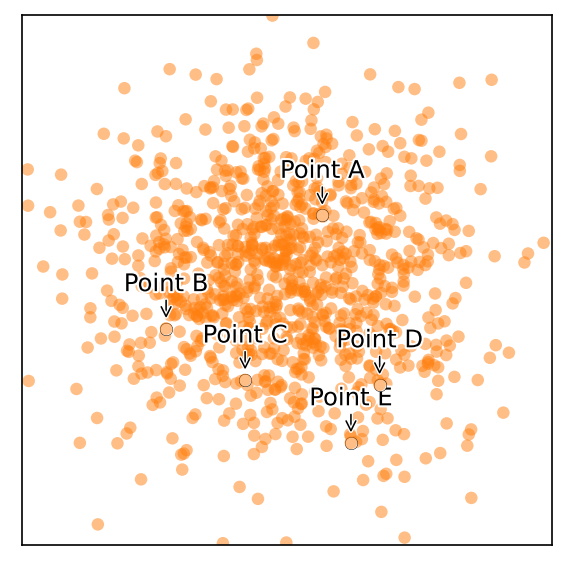

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1, xlim=[-1, +1], xticks=[], ylim=[-1, +1], yticks=[], aspect=1)

np.random.seed(123)
X = np.random.normal(0, 0.35, 1000)
Y = np.random.normal(0, 0.35, 1000)

ax.scatter(X, Y, edgecolor="None", facecolor="C1", alpha=0.5)

I = np.random.choice(len(X), size=5, replace=False)
Px, Py = X[I], Y[I]
I = np.argsort(Y[I])[::-1]
Px, Py = Px[I], Py[I]

ax.scatter(Px, Py, edgecolor="black", facecolor="white", zorder=20)
ax.scatter(Px, Py, edgecolor="None", facecolor="C1", alpha=0.5, zorder=30)

y, dy = 1.0, 0.125
style = "arc,angleA=-0,angleB=0,armA=-100,armB=0,rad=0"

for i in range(len(I)):
    text = ax.annotate(
        "Point " + chr(ord("A") + i),
        xy=(Px[i], Py[i]),
        xycoords="data",
        xytext=(0, 18),
        textcoords="offset points",
        ha="center",
        size="small",
        arrowprops=dict(
            arrowstyle="->", shrinkA=0, shrinkB=5, color="black", linewidth=0.75
        ),
    )
    text.set_path_effects(
        [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
    )
    text.arrow_patch.set_path_effects(
        [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()]
    )

plt.tight_layout()

In [53]:
I

array([3, 0, 4, 1, 2])